In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score

In [3]:
df = pd.read_csv('credit_data.csv')
df.head()

,customer_id,age,gender,location,monthly_income,monthly_emi_outflow,current_outstanding,credit_utilization_ratio,num_open_loans,repayment_history_score,dpd_last_3_months,num_hard_inquiries_last_6m,recent_credit_card_usage,recent_loan_disbursed_amount,total_credit_limit,months_since_last_default,target_credit_score_movement
0,CUST00001,56,M,Semi-Urban,154867,860,365838,2.36,3,71,60,4,54886,137337,531430,10,decrease
1,CUST00002,28,M,Semi-Urban,120727,44131,191335,1.58,3,21,52,1,59735,194027,337069,1,stable
2,CUST00003,41,M,Metropolitan,229176,85305,989436,4.32,4,88,48,2,25658,346622,394681,27,stable
3,CUST00004,35,F,Urban,75725,19118,67435,0.89,4,63,56,2,69092,3890,575894,20,stable
4,CUST00005,29,M,Metropolitan,488254,349457,1465689,3.00,5,1,19,3,23483,386502,582843,7,decrease


In [4]:
df['target_credit_score_movement'].value_counts()

stable      15915
decrease     7806
increase     1279
Name: target_credit_score_movement, dtype: int64

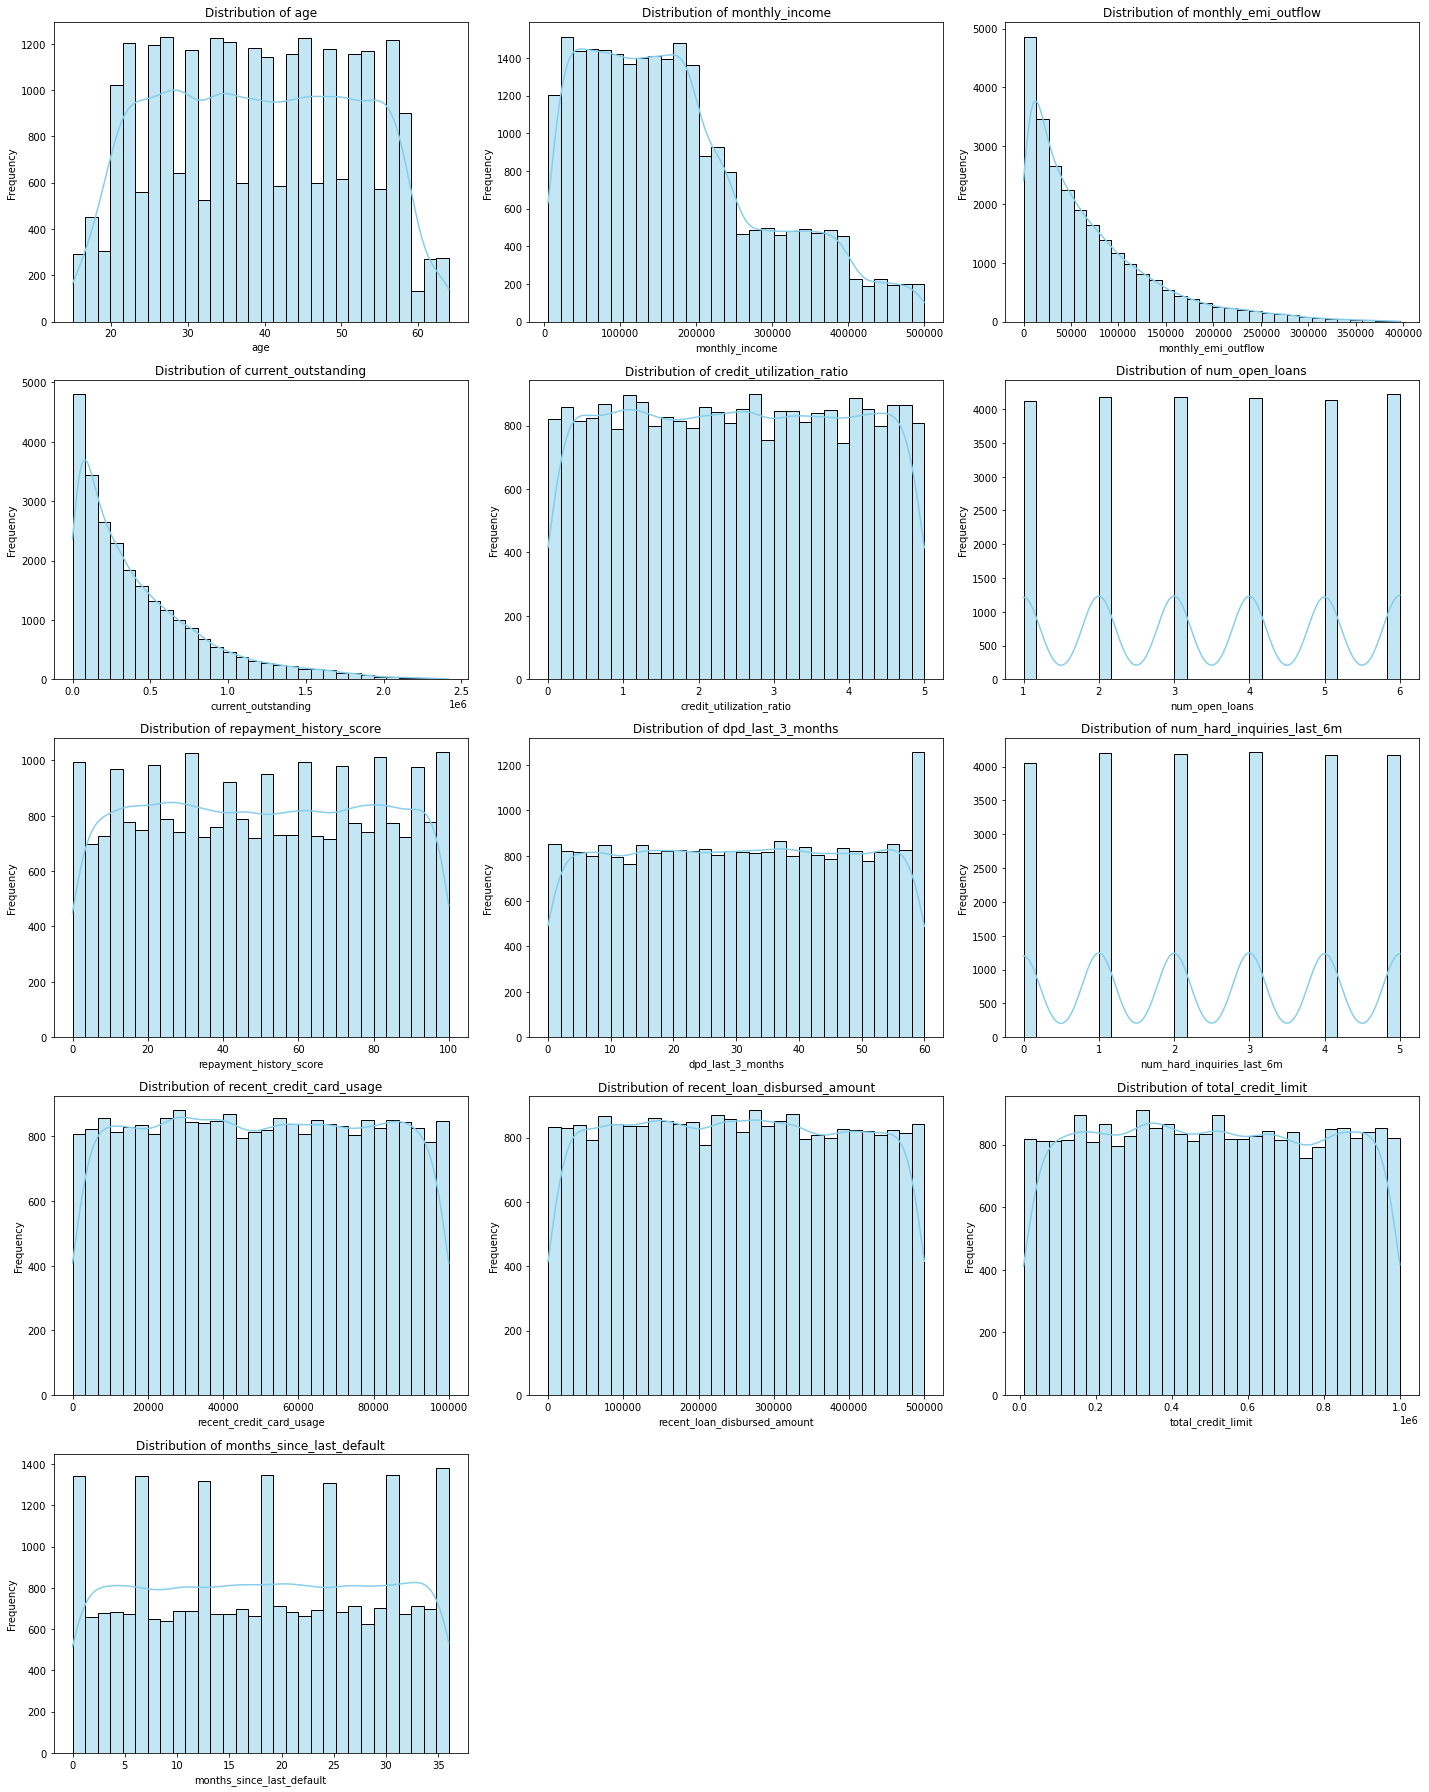

In [5]:
numeric_cols = [
    "age", "monthly_income", "monthly_emi_outflow", "current_outstanding",
    "credit_utilization_ratio", "num_open_loans", "repayment_history_score",
    "dpd_last_3_months", "num_hard_inquiries_last_6m", "recent_credit_card_usage",
    "recent_loan_disbursed_amount", "total_credit_limit", "months_since_last_default"
]

#Histogramsfor distribution analysis
plt.figure(figsize=(20, 25))
for idx, col in enumerate(numeric_cols):
    plt.subplot(5, 3, idx + 1)
    sns.histplot(df[col], kde=True, bins=30, color="skyblue")
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [6]:
len(df)

25000

In [7]:
#Outlier Removal
def remove_outliers_iqr(df, column):
    Q1=df[column].quantile(0.25)
    Q3=df[column].quantile(0.75)
    IQR=Q3-Q1
    lower=Q1-1.5*IQR
    upper=Q3+1.5*IQR
    return df[(df[column]>=lower) & (df[column]<=upper)]

In [8]:
# Apply to skewed numeric columns
for col in ['monthly_income', 'monthly_emi_outflow', 'current_outstanding']:
    df = remove_outliers_iqr(df, col)

In [9]:
df = df.drop_duplicates()
print("Number of points:", len(df))

Number of points: 22696


In [10]:
#Checking for null values
print(df.isnull().sum())

customer_id                     0
age                             0
gender                          0
location                        0
monthly_income                  0
monthly_emi_outflow             0
current_outstanding             0
credit_utilization_ratio        0
num_open_loans                  0
repayment_history_score         0
dpd_last_3_months               0
num_hard_inquiries_last_6m      0
recent_credit_card_usage        0
recent_loan_disbursed_amount    0
total_credit_limit              0
months_since_last_default       0
target_credit_score_movement    0
dtype: int64


In [11]:
#Hence, no need for null values imputation

In [13]:
#Encoding categorical variables
df_final = df.copy()
label_encoders = {}
for col in ['gender', 'location']:
    le = LabelEncoder()
    df_final[col] = le.fit_transform(df_final[col])
    label_encoders[col] = le

X = df_final.drop(['customer_id', 'target_credit_score_movement'], axis=1)
y = df_final['target_credit_score_movement']

# Encode target labels
y = LabelEncoder().fit_transform(y)

In [14]:
df['target_credit_score_movement'].value_counts()

stable      14453
decrease     7028
increase     1215
Name: target_credit_score_movement, dtype: int64

In [15]:
#'Increase' class is much under represented. Calls for oversampling.

In [17]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train_bal).value_counts())

Class distribution after SMOTE:
0    11562
2    11562
1    11562
dtype: int64


In [18]:
#Trying on different models

#Import models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Logistic Regression has an accuracy of 0.5302 and F1 score of 0.5578


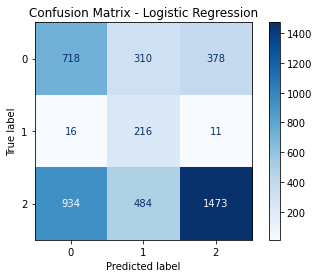

In [24]:
#Logistic Regression

lr=LogisticRegression(max_iter=500)
lr.fit(X_train_bal,y_train_bal)
lr_pred=lr.predict(X_test)
lr_accuracy=accuracy_score(y_test,lr_pred)
lr_f1=f1_score(y_test,lr_pred,average='weighted')
print(f"Logistic Regression has an accuracy of {lr_accuracy:.4f} and F1 score of {lr_f1:.4f}")
#Compute confusion matrix
cm=confusion_matrix(y_test, lr_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

Logistic Regression has an accuracy of 0.5302 and F1 score of 0.5578


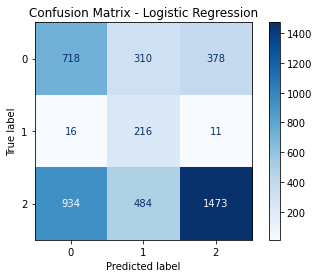

In [25]:
#On increasing number of iterations
lr=LogisticRegression(max_iter=1500)
lr.fit(X_train_bal,y_train_bal)
lr_pred=lr.predict(X_test)
lr_accuracy=accuracy_score(y_test,lr_pred)
lr_f1=f1_score(y_test,lr_pred,average='weighted')
print(f"Logistic Regression has an accuracy of {lr_accuracy:.4f} and F1 score of {lr_f1:.4f}")
#Compute confusion matrix
cm=confusion_matrix(y_test, lr_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [ ]:
#As credit data will majorly be of tree type(categorized by multiple factors), tree models works the best and remaining like a simple logistic regression will not.

Decision Tree has an accuracy of 0.9797 and F1 score of 0.9811


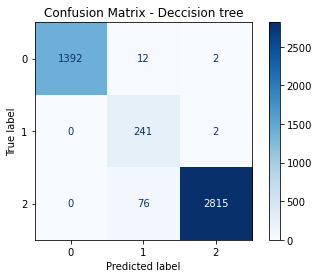

In [31]:
#Decision Tree model
dt=DecisionTreeClassifier(max_depth=10,min_samples_split=30,min_samples_leaf=10,max_leaf_nodes=35,random_state=42)
dt.fit(X_train_bal,y_train_bal)
dt_pred=dt.predict(X_test)
dt_accuracy=accuracy_score(y_test,dt_pred)
dt_f1=f1_score(y_test,dt_pred,average='weighted')
print(f"Decision Tree has an accuracy of {dt_accuracy:.4f} and F1 score of {dt_f1:.4f}")
#Compute confusion matrix
cm=confusion_matrix(y_test, dt_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Decision tree")
plt.show()

In [36]:
#Now that the model is working fine, let's check training accuracy
Training_accuracy_dt=accuracy_score(y_train,dt.predict(X_train))
print(Training_accuracy_dt)

0.9832562238378497


In [38]:
#This suggests that the model is not overperforming, let's try on random forest too

Random Forest has an accuracy of 0.9727 and F1 score of 0.9750


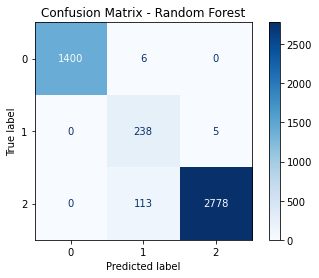

In [41]:
#Random Forest model
rf=RandomForestClassifier(n_estimators=150,max_depth=10,min_samples_split=20,min_samples_leaf=10,random_state=42)
rf.fit(X_train_bal,y_train_bal)
rf_pred=rf.predict(X_test)
rf_accuracy=accuracy_score(y_test,rf_pred)
rf_f1=f1_score(y_test,rf_pred,average='weighted')
print(f"Random Forest has an accuracy of {rf_accuracy:.4f} and F1 score of {rf_f1:.4f}")
#Compute confusion matrix
cm=confusion_matrix(y_test, rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [42]:
print("Random Forest Classification Report:\n", classification_report(y_test, rf_pred))
print("Decision Tree Classification Report:\n", classification_report(y_test, dt_pred))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1406
           1       0.67      0.98      0.79       243
           2       1.00      0.96      0.98      2891

    accuracy                           0.97      4540
   macro avg       0.89      0.98      0.92      4540
weighted avg       0.98      0.97      0.98      4540

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1406
           1       0.73      0.99      0.84       243
           2       1.00      0.97      0.99      2891

    accuracy                           0.98      4540
   macro avg       0.91      0.99      0.94      4540
weighted avg       0.98      0.98      0.98      4540



In [43]:
#As decision tree is working the best, let's move on to optimizing its hyperparameters

from sklearn.model_selection import GridSearchCV

#Base model
DT=DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [8, 10, 12],
    'min_samples_split': [20, 30, 40],
    'min_samples_leaf': [5, 10, 15],
    'max_leaf_nodes': [30, 35, 40]
}
grid_search = GridSearchCV(estimator=dt,param_grid=param_grid,cv=5,scoring='f1_weighted',verbose=1,n_jobs=-1)

import time
start = time.time()
grid_search.fit(X_train_bal, y_train_bal)
end = time.time()

best_dt = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [44]:
# Evaluation
y_pred = best_dt.predict(X_test)
print("Best Parameters:", grid_search.best_params_)
print(f"Training time: {end - start:.2f} seconds\n")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

Best Parameters: {'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_leaf': 15, 'min_samples_split': 20}
Training time: 14.75 seconds

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      1406
           1       0.74      0.97      0.84       243
           2       1.00      0.97      0.99      2891

    accuracy                           0.98      4540
   macro avg       0.91      0.98      0.94      4540
weighted avg       0.98      0.98      0.98      4540

Accuracy Score: 0.9795154185022027
F1 Score: 0.980774528419346


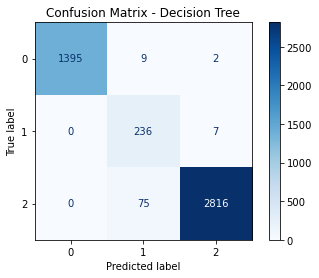

In [45]:
#confusion matrix
cm=confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Decision Tree")
plt.show()

0.9874589171423629


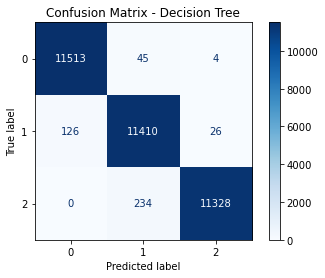

Classification Report on Training data:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     11562
           1       0.98      0.99      0.98     11562
           2       1.00      0.98      0.99     11562

    accuracy                           0.99     34686
   macro avg       0.99      0.99      0.99     34686
weighted avg       0.99      0.99      0.99     34686



In [49]:
#Training accuracy
Training_accuracy_dt=accuracy_score(y_train_bal,best_dt.predict(X_train_bal))
print(Training_accuracy_dt)
#confusion matrix
cm=confusion_matrix(y_train_bal,best_dt.predict(X_train_bal))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Decision Tree")
plt.show()

print("Classification Report on Training data:\n", classification_report(y_train_bal,best_dt.predict(X_train_bal)))

In [ ]:
#In conclusion, The Decision Tree model gave a training accuracy of 98.75% and test accuracy of 97.9% (target variable is written based on certain features so the decision tree model is able to learn them)